# Prophet 모델 이용하여 일별 시간대별 취급액, 판매량 예측

 Facebook Prophet 모델을 이용해 일별 취급액, 판매량을 예측해 본다. ~~(망한)~~ LSTM 모델의 전반적인 성능과 비교하기 위함이다. 11월까지의 데이터를 train에, 12월까지의 데이터를 test에 이용한다.
 
 - 취급액 합계 : standard scaling 진행.
 - 판매량 합계 : scaling 없이 진행.

# 결과
 
 ~~LSTM이 코드를 잘못 짰던 걸로~~.

 Prophet 모델만 놓고 봤을 때는 daily보다는 hourly로 보는 게 나아 보인다. 시간대별로 주기성이 안 보이던 게 보인다!
 - changepoint scale 줄여서 덜 flexible하게 만들었을 때 MAPE 스코어 조금 더 향상.
 - logistic으로 하면 더 좋다!

 domain 활용해서 logistic cap, floor 등 바꿔 주자.

In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

from fbprophet import Prophet

In [2]:
# 그래프 출력 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [3]:
# 경로 변경
os.chdir('/content/drive/My Drive/Big-Contest')
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [4]:
# 경로 설정
RAW_DATA = './data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'

In [5]:
# 데이터 로드 및 기본 전처리
data_raw = pd.read_excel(RAW_DATA, header=1)
data = data_raw[data_raw['상품군'] != '무형'] # 무형 상품군 제외
data['노출(분)'] = data['노출(분)'].fillna(method='ffill') # 노출 결측치 처리
data['취급액'] = data['취급액'].fillna(0) # 취급액 0원인 상품 처리
data = data[data['방송일시'].dt.year != 2020] # 2020년 데이터 제외
data = data.reset_index(drop=True)

In [6]:
# 판매량 컬럼 생성
data['판매량'] = data['취급액'] / data['판매단가']

In [7]:
# 집계 기준 컬럼 생성
data['날짜'] = data['방송일시'].dt.date
data['날짜시간'] = data['방송일시'].dt.floor('H')
data['날짜'] = pd.to_datetime(data['날짜'])
data['날짜시간'] = pd.to_datetime(data['날짜시간'])
data.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,날짜,날짜시간
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01,2019-01-01 06:00:00
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01,2019-01-01 06:00:00
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01,2019-01-01 06:00:00
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01,2019-01-01 06:00:00
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01,2019-01-01 06:00:00
5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,234.010025,2019-01-01,2019-01-01 06:00:00
6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000.0,115.576271,2019-01-01,2019-01-01 07:00:00
7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000.0,265.915254,2019-01-01,2019-01-01 07:00:00
8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,430.000000,2019-01-01,2019-01-01 07:00:00
9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000.0,269.332220,2019-01-01,2019-01-01 08:00:00


In [8]:
# MAPE 스코어 산식
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 시간대별 취급액 합계
- standard scale
- log transform

In [9]:
# 시간대별 취급액 합계
hourly = pd.DataFrame(data.groupby(by='날짜시간', as_index=True)['취급액'].sum())
scaler = StandardScaler()
scaler.fit(hourly[['취급액']])
hourly['취급액_scaled'] = scaler.transform(hourly[['취급액']])
hourly['취급액_log'] = np.log1p(hourly['취급액'])

In [10]:
# 트레인 테스트 셋 분리
df_train = hourly[hourly.index.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
df_test = hourly[hourly.index.month.isin([12])]
display(df_train)
display(df_test)

,취급액,취급액_scaled,취급액_log
날짜시간,,,
2019-01-01 06:00:00,32696000.0,-1.554704,17.302763
2019-01-01 07:00:00,47878000.0,-1.267379,17.684167
2019-01-01 08:00:00,99736000.0,-0.285949,18.418037
2019-01-01 09:00:00,90973000.0,-0.451792,18.326073
2019-01-01 10:00:00,259678000.0,2.741008,19.374953
...,...,...,...
2019-11-30 19:00:00,161086000.0,0.875121,18.897449
2019-11-30 20:00:00,185150000.0,1.330540,19.036677
2019-11-30 21:00:00,225998000.0,2.103603,19.236037


,취급액,취급액_scaled,취급액_log
날짜시간,,,
2019-12-01 00:00:00,54697000.0,-1.138328,17.817319
2019-12-01 01:00:00,42594000.0,-1.367381,17.567224
2019-12-01 02:00:00,24324000.0,-1.713147,17.006974
2019-12-01 06:00:00,36807000.0,-1.476902,17.421199
2019-12-01 07:00:00,81450000.0,-0.632018,18.215500
...,...,...,...
2019-12-31 19:00:00,177729000.0,1.190095,18.995770
2019-12-31 20:00:00,143410000.0,0.540596,18.781218
2019-12-31 21:00:00,219941000.0,1.988972,19.208870


### _1_. default 설정


In [11]:
# Prophet 모델에 맞게 데이터셋 구성
train = df_train.reset_index(drop=False).rename(columns={'날짜시간':'ds', '취급액_scaled':'y'})
test = df_test.reset_index(drop=False)[['날짜시간']].rename(columns={'날짜시간':'ds'})
display(train)
display(test)

,ds,취급액,y
0,2019-01-01 06:00:00,32696000.0,-1.554704
1,2019-01-01 07:00:00,47878000.0,-1.267379
2,2019-01-01 08:00:00,99736000.0,-0.285949
3,2019-01-01 09:00:00,90973000.0,-0.451792
4,2019-01-01 10:00:00,259678000.0,2.741008
...,...,...,...
6486,2019-11-30 19:00:00,161086000.0,0.875121
6487,2019-11-30 20:00:00,185150000.0,1.330540
6488,2019-11-30 21:00:00,225998000.0,2.103603
6489,2019-11-30 22:00:00,250544000.0,2.568144


,ds
0,2019-12-01 00:00:00
1,2019-12-01 01:00:00
2,2019-12-01 02:00:00
3,2019-12-01 06:00:00
4,2019-12-01 07:00:00
...,...
619,2019-12-31 19:00:00
620,2019-12-31 20:00:00
621,2019-12-31 21:00:00
622,2019-12-31 22:00:00


In [ ]:
# prophet 모델 훈련 및 예측
m = Prophet()
m.fit(train)
forecast = m.predict(test)
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-01 00:00:00,-0.043563,-0.863005,1.024375,-0.043563,-0.043563,0.133024,0.133024,0.133024,-0.256673,-0.256673,-0.256673,0.389696,0.389696,0.389696,0.0,0.0,0.0,0.089460
1,2019-12-01 01:00:00,-0.043450,-1.736691,0.205047,-0.043450,-0.043450,-0.763867,-0.763867,-0.763867,-1.156113,-1.156113,-1.156113,0.392246,0.392246,0.392246,0.0,0.0,0.0,-0.807317
2,2019-12-01 02:00:00,-0.043337,-2.234578,-0.375917,-0.043337,-0.043337,-1.263831,-1.263831,-1.263831,-1.656930,-1.656930,-1.656930,0.393100,0.393100,0.393100,0.0,0.0,0.0,-1.307167
3,2019-12-01 06:00:00,-0.042883,-1.445821,0.545527,-0.042883,-0.042883,-0.389700,-0.389700,-0.389700,-0.769222,-0.769222,-0.769222,0.379522,0.379522,0.379522,0.0,0.0,0.0,-0.432584
4,2019-12-01 07:00:00,-0.042770,-1.009953,0.868465,-0.042770,-0.042770,-0.036019,-0.036019,-0.036019,-0.407997,-0.407997,-0.407997,0.371978,0.371978,0.371978,0.0,0.0,0.0,-0.078789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2019-12-31 19:00:00,0.040152,-0.557805,1.431358,0.027074,0.054142,0.366442,0.366442,0.366442,0.456024,0.456024,0.456024,-0.089581,-0.089581,-0.089581,0.0,0.0,0.0,0.406594
620,2019-12-31 20:00:00,0.040265,-0.168426,1.689391,0.027167,0.054296,0.709867,0.709867,0.709867,0.796041,0.796041,0.796041,-0.086174,-0.086174,-0.086174,0.0,0.0,0.0,0.750132
621,2019-12-31 21:00:00,0.040378,0.168520,2.088344,0.027260,0.054447,1.094847,1.094847,1.094847,1.177926,1.177926,1.177926,-0.083079,-0.083079,-0.083079,0.0,0.0,0.0,1.135225
622,2019-12-31 22:00:00,0.040492,0.223100,2.146963,0.027354,0.054595,1.126372,1.126372,1.126372,1.206674,1.206674,1.206674,-0.080302,-0.080302,-0.080302,0.0,0.0,0.0,1.166863


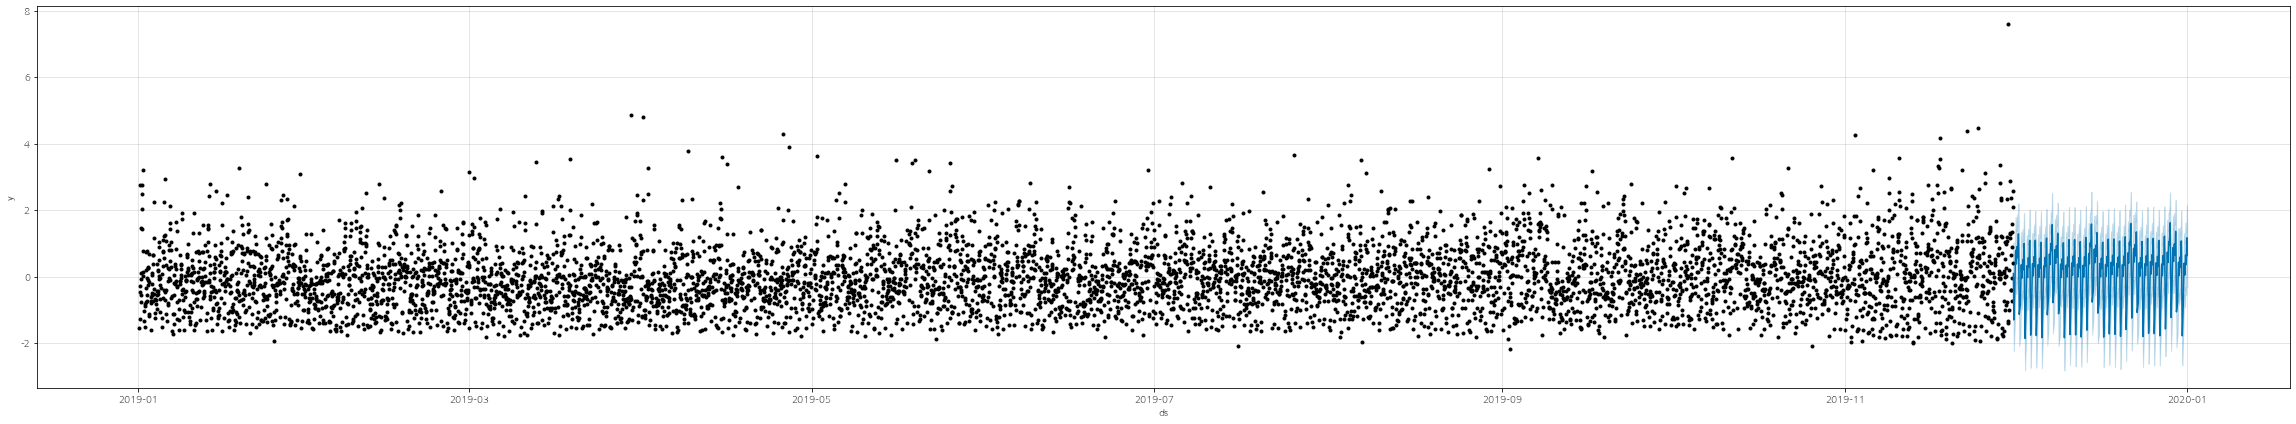

In [ ]:
# prophet plot
m.plot(forecast, figsize=(32, 6));

In [ ]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
hourly['취급액_예측_pred'] = forecast['yhat']
hourly['취급액_예측_lower'] = forecast['yhat_lower']
hourly['취급액_예측_upper'] = forecast['yhat_upper']
hourly

,취급액,취급액_scaled,취급액_예측_pred,취급액_예측_lower,취급액_예측_upper
날짜시간,,,,,
2019-01-01 06:00:00,32696000.0,-1.554704,NaN,NaN,NaN
2019-01-01 07:00:00,47878000.0,-1.267379,NaN,NaN,NaN
2019-01-01 08:00:00,99736000.0,-0.285949,NaN,NaN,NaN
2019-01-01 09:00:00,90973000.0,-0.451792,NaN,NaN,NaN
2019-01-01 10:00:00,259678000.0,2.741008,NaN,NaN,NaN
...,...,...,...,...,...
2019-12-31 19:00:00,177729000.0,1.190095,0.406594,-0.557805,1.431358
2019-12-31 20:00:00,143410000.0,0.540596,0.750132,-0.168426,1.689391
2019-12-31 21:00:00,219941000.0,1.988972,1.135225,0.168520,2.088344


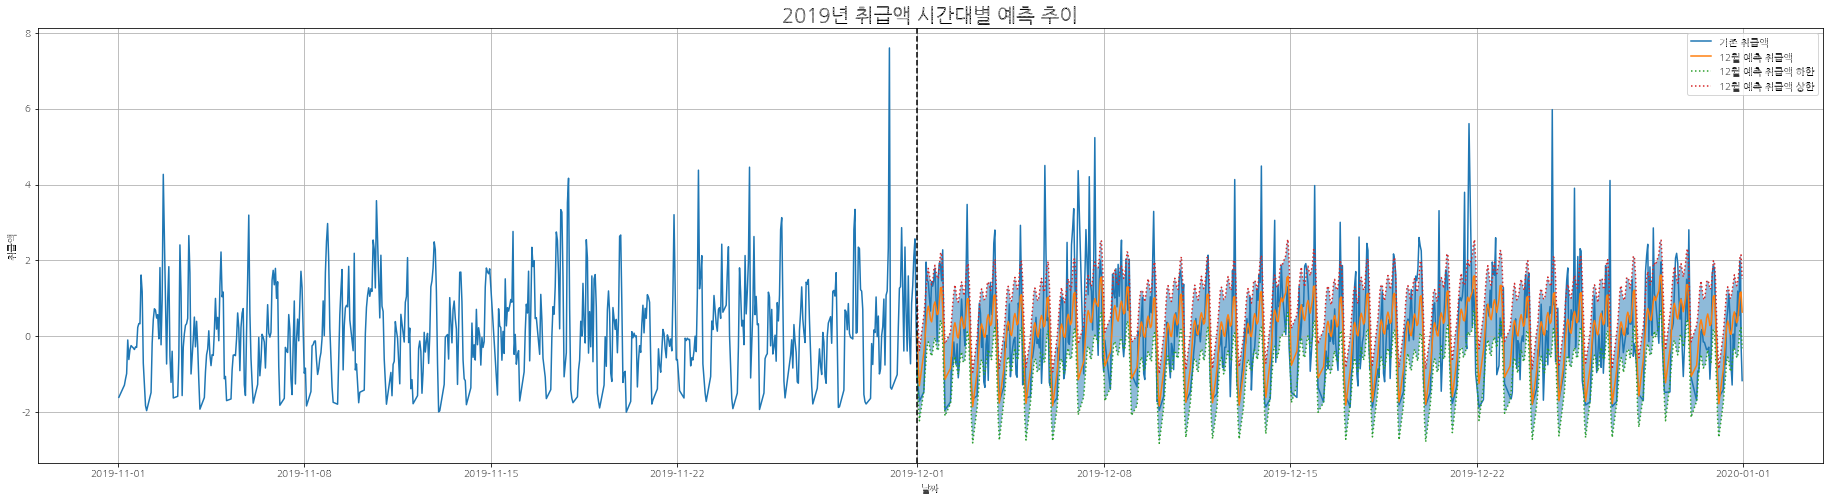

In [ ]:
# 시각화
hourly_for_plot = hourly[hourly.index.month.isin([11, 12])]
hourly_for_plot

plt.figure(figsize=(32, 8))
plt.plot(hourly_for_plot['취급액_scaled'], label='기존 취급액')
plt.plot(hourly_for_plot['취급액_예측_pred'], label='12월 예측 취급액')
plt.plot(hourly_for_plot['취급액_예측_lower'], linestyle='dotted', label='12월 예측 취급액 하한')
plt.plot(hourly_for_plot['취급액_예측_upper'], linestyle='dotted', label='12월 예측 취급액 상한')
plt.fill_between(hourly_for_plot.index, hourly_for_plot['취급액_예측_lower'], hourly_for_plot['취급액_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-12-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('취급액')
plt.title('2019년 취급액 시간대별 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# 스코어 측정
hourly['취급액_예측_inverse'] = scaler.inverse_transform(hourly['취급액_예측_pred'])
hourly_for_score = hourly.dropna()
print("MAPE:", mean_absolute_percentage_error(hourly_for_score['취급액'], hourly_for_score['취급액_예측_inverse']))

MAPE: 41.546031070766915


### _2_. logistic growth

In [13]:
# Prophet 모델에 맞게 데이터셋 구성 + log 변환된 데이터셋
hourly['취급액_log'] = np.log1p(hourly['취급액'])
train = df_train.reset_index(drop=False)[['날짜시간', '취급액_log']].rename(columns={'날짜시간':'ds', '취급액_log':'y'})
test = df_test.reset_index(drop=False)[['날짜시간']].rename(columns={'날짜시간':'ds'})
display(train)
display(test)

,ds,y
0,2019-01-01 06:00:00,17.302763
1,2019-01-01 07:00:00,17.684167
2,2019-01-01 08:00:00,18.418037
3,2019-01-01 09:00:00,18.326073
4,2019-01-01 10:00:00,19.374953
...,...,...
6486,2019-11-30 19:00:00,18.897449
6487,2019-11-30 20:00:00,19.036677
6488,2019-11-30 21:00:00,19.236037
6489,2019-11-30 22:00:00,19.339145


,ds
0,2019-12-01 00:00:00
1,2019-12-01 01:00:00
2,2019-12-01 02:00:00
3,2019-12-01 06:00:00
4,2019-12-01 07:00:00
...,...
619,2019-12-31 19:00:00
620,2019-12-31 20:00:00
621,2019-12-31 21:00:00
622,2019-12-31 22:00:00


In [22]:
# logistic cap, floor 설정
train['cap'] = 21
train['floor'] = 15
test['cap'] = 21
test['floor'] = 15

In [23]:
# prophet 모델 훈련 및 예측
m = Prophet(growth='logistic')
m.fit(train)
forecast = m.predict(test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [24]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
hourly['취급액_예측_pred'] = forecast['yhat']
hourly['취급액_예측_lower'] = forecast['yhat_lower']
hourly['취급액_예측_upper'] = forecast['yhat_upper']
hourly

,취급액,취급액_scaled,취급액_log,취급액_예측_pred,취급액_예측_lower,취급액_예측_upper
날짜시간,,,,,,
2019-01-01 06:00:00,32696000.0,-1.554704,17.302763,NaN,NaN,NaN
2019-01-01 07:00:00,47878000.0,-1.267379,17.684167,NaN,NaN,NaN
2019-01-01 08:00:00,99736000.0,-0.285949,18.418037,NaN,NaN,NaN
2019-01-01 09:00:00,90973000.0,-0.451792,18.326073,NaN,NaN,NaN
2019-01-01 10:00:00,259678000.0,2.741008,19.374953,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-12-31 19:00:00,177729000.0,1.190095,18.995770,18.604430,18.063457,19.108708
2019-12-31 20:00:00,143410000.0,0.540596,18.781218,18.716105,18.190275,19.247580
2019-12-31 21:00:00,219941000.0,1.988972,19.208870,18.887396,18.389309,19.432864


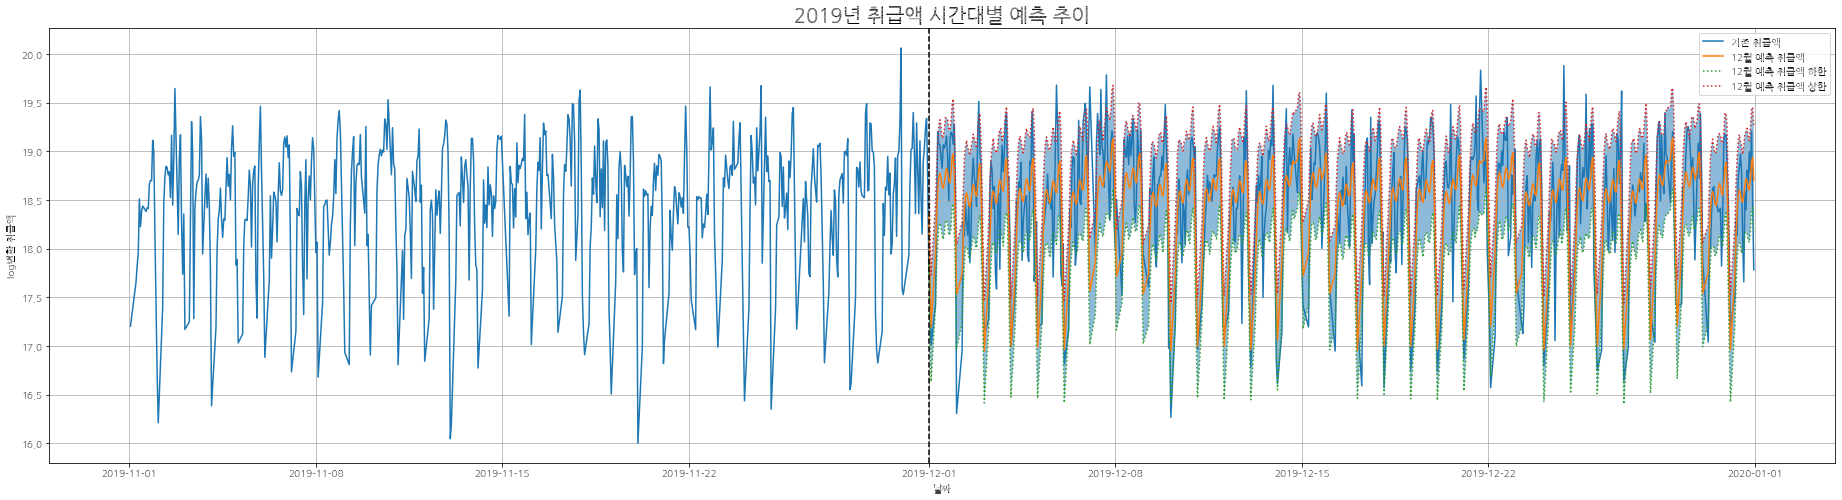

In [29]:
# 시각화
hourly_for_plot = hourly[hourly.index.month.isin([11, 12])]
hourly_for_plot

plt.figure(figsize=(32, 8))
plt.plot(hourly_for_plot['취급액_log'], label='기존 취급액')
plt.plot(hourly_for_plot['취급액_예측_pred'], label='12월 예측 취급액')
plt.plot(hourly_for_plot['취급액_예측_lower'], linestyle='dotted', label='12월 예측 취급액 하한')
plt.plot(hourly_for_plot['취급액_예측_upper'], linestyle='dotted', label='12월 예측 취급액 상한')
plt.fill_between(hourly_for_plot.index, hourly_for_plot['취급액_예측_lower'], hourly_for_plot['취급액_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-12-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('log변환 취급액')
plt.title('2019년 취급액 시간대별 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

In [26]:
# 스코어 측정
hourly['취급액_예측_inverse'] = np.expm1(hourly['취급액_예측_pred'])
hourly_for_score = hourly.dropna()
print("MAPE:", mean_absolute_percentage_error(hourly_for_score['취급액'], hourly_for_score['취급액_예측_inverse']))

MAPE: 34.968046577699255


### _3_. changepoint 변경: flexibility 감소


In [42]:
# prophet 모델 훈련 및 예측
m = Prophet(growth='logistic')
m.fit(train)
forecast = m.predict(test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


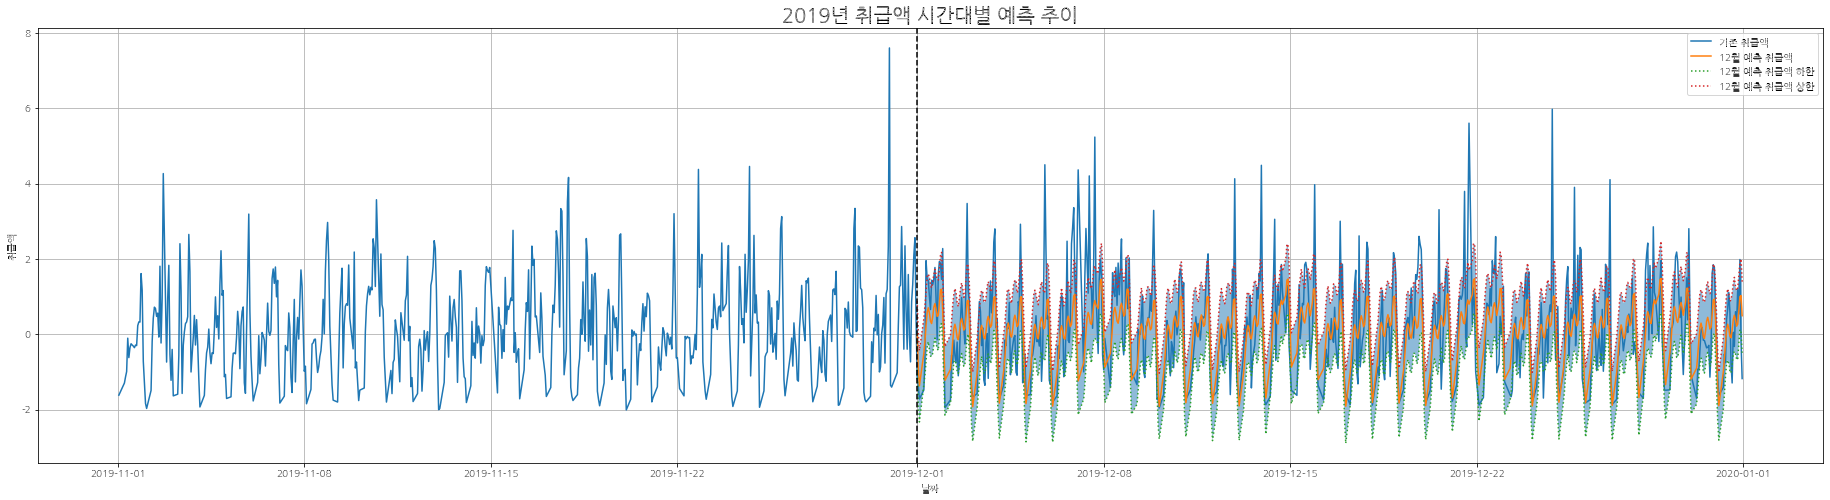

In [43]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
hourly['취급액_예측_pred'] = forecast['yhat']
hourly['취급액_예측_lower'] = forecast['yhat_lower']
hourly['취급액_예측_upper'] = forecast['yhat_upper']

# 시각화
hourly_for_plot = hourly[hourly.index.month.isin([11, 12])]
hourly_for_plot

plt.figure(figsize=(32, 8))
plt.plot(hourly_for_plot['취급액_scaled'], label='기존 취급액')
plt.plot(hourly_for_plot['취급액_예측_pred'], label='12월 예측 취급액')
plt.plot(hourly_for_plot['취급액_예측_lower'], linestyle='dotted', label='12월 예측 취급액 하한')
plt.plot(hourly_for_plot['취급액_예측_upper'], linestyle='dotted', label='12월 예측 취급액 상한')
plt.fill_between(hourly_for_plot.index, hourly_for_plot['취급액_예측_lower'], hourly_for_plot['취급액_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-12-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('취급액')
plt.title('2019년 취급액 시간대별 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

In [44]:
# 스코어 측정
hourly['취급액_예측_inverse'] = scaler.inverse_transform(hourly['취급액_예측_pred'])
hourly_for_score = hourly.dropna()
print("MAPE:", mean_absolute_percentage_error(hourly_for_score['취급액'], hourly_for_score['취급액_예측_inverse']))

MAPE: 38.97480046025768


### _4_. holiday 추가

In [71]:
holiday_df = pd.read_csv("./data/holiday_prophet_1차.csv")
holiday_df

,holiday,ds,lower_window,upper_window
0,신정,2019-01-01,0,2
1,설날,2019-02-04,-30,2
2,설날,2019-02-05,-30,2
3,설날,2019-02-06,-30,2
4,추석,2019-09-12,-30,2
5,추석,2019-09-13,-30,2
6,추석,2019-09-14,-30,2
7,공휴일,2019-03-01,0,0
8,공휴일,2019-05-05,0,0
9,공휴일,2019-05-06,0,0


In [58]:
# prophet 모델 훈련 및 예측
m = Prophet(holidays=holiday_df)
m.fit(train)
forecast = m.predict(test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


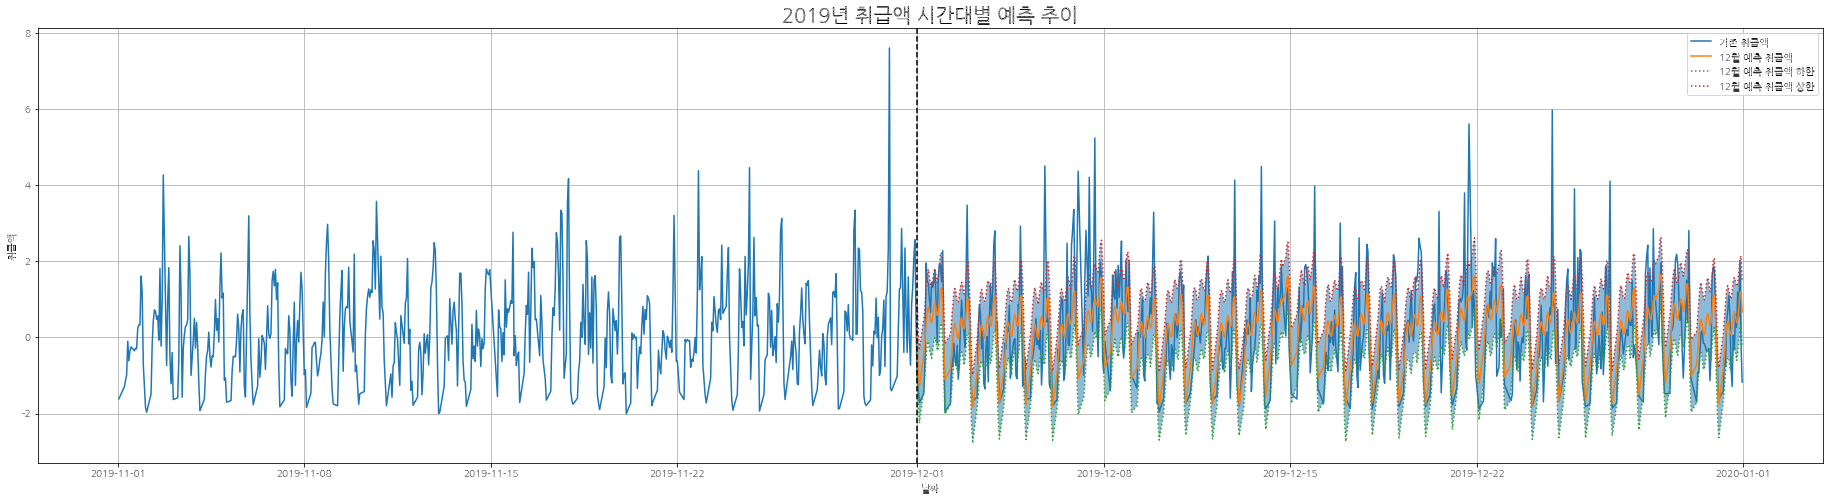

In [54]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
hourly['취급액_예측_pred'] = forecast['yhat']
hourly['취급액_예측_lower'] = forecast['yhat_lower']
hourly['취급액_예측_upper'] = forecast['yhat_upper']

# 시각화
hourly_for_plot = hourly[hourly.index.month.isin([11, 12])]
hourly_for_plot

plt.figure(figsize=(32, 8))
plt.plot(hourly_for_plot['취급액_scaled'], label='기존 취급액')
plt.plot(hourly_for_plot['취급액_예측_pred'], label='12월 예측 취급액')
plt.plot(hourly_for_plot['취급액_예측_lower'], linestyle='dotted', label='12월 예측 취급액 하한')
plt.plot(hourly_for_plot['취급액_예측_upper'], linestyle='dotted', label='12월 예측 취급액 상한')
plt.fill_between(hourly_for_plot.index, hourly_for_plot['취급액_예측_lower'], hourly_for_plot['취급액_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-12-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('취급액')
plt.title('2019년 취급액 시간대별 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

In [55]:
# 스코어 측정
hourly['취급액_예측_inverse'] = scaler.inverse_transform(hourly['취급액_예측_pred'])
hourly_for_score = hourly.dropna()
print("MAPE:", mean_absolute_percentage_error(hourly_for_score['취급액'], hourly_for_score['취급액_예측_inverse']))

MAPE: 42.50892661402044


## 시간대별 판매량 합계

In [ ]:
# 시간대별 판매량 합계 집계
hourly = pd.DataFrame(data.groupby(by='날짜시간', as_index=True)['판매량'].sum())
# scaler = StandardScaler()
# scaler.fit(hourly[['취급액']])
# hourly['취급액_scaled'] = scaler.transform(hourly[['취급액']])
hourly

,판매량
날짜시간,
2019-01-01 06:00:00,819.448622
2019-01-01 07:00:00,811.491525
2019-01-01 08:00:00,1665.041736
2019-01-01 09:00:00,1151.556962
2019-01-01 10:00:00,3250.037547
...,...
2019-12-31 19:00:00,1716.880753
2019-12-31 20:00:00,432.121912
2019-12-31 21:00:00,496.086853


In [ ]:
# 트레인 테스트 셋 분리
df_train = hourly[hourly.index.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
df_test = hourly[hourly.index.month.isin([12])]
display(df_train)
display(df_test)

,판매량
날짜시간,
2019-01-01 06:00:00,819.448622
2019-01-01 07:00:00,811.491525
2019-01-01 08:00:00,1665.041736
2019-01-01 09:00:00,1151.556962
2019-01-01 10:00:00,3250.037547
...,...
2019-11-30 19:00:00,1088.473719
2019-11-30 20:00:00,1185.568005
2019-11-30 21:00:00,603.270862


,판매량
날짜시간,
2019-12-01 00:00:00,393.503597
2019-12-01 01:00:00,1067.518797
2019-12-01 02:00:00,609.624060
2019-12-01 06:00:00,413.561798
2019-12-01 07:00:00,560.288070
...,...
2019-12-31 19:00:00,1716.880753
2019-12-31 20:00:00,432.121912
2019-12-31 21:00:00,496.086853


In [ ]:
# Prophet 모델에 맞게 데이터셋 구성
train = df_train.reset_index(drop=False).rename(columns={'날짜시간':'ds', '판매량':'y'})
test = df_test.reset_index(drop=False)[['날짜시간']].rename(columns={'날짜시간':'ds'})
display(train)
display(test)

,ds,y
0,2019-01-01 06:00:00,819.448622
1,2019-01-01 07:00:00,811.491525
2,2019-01-01 08:00:00,1665.041736
3,2019-01-01 09:00:00,1151.556962
4,2019-01-01 10:00:00,3250.037547
...,...,...
6486,2019-11-30 19:00:00,1088.473719
6487,2019-11-30 20:00:00,1185.568005
6488,2019-11-30 21:00:00,603.270862
6489,2019-11-30 22:00:00,223.051566


,ds
0,2019-12-01 00:00:00
1,2019-12-01 01:00:00
2,2019-12-01 02:00:00
3,2019-12-01 06:00:00
4,2019-12-01 07:00:00
...,...
619,2019-12-31 19:00:00
620,2019-12-31 20:00:00
621,2019-12-31 21:00:00
622,2019-12-31 22:00:00


In [ ]:
# prophet 모델 훈련 및 예측
m = Prophet()
m.fit(train)
forecast = m.predict(test)
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-01 00:00:00,1535.613931,75.889630,2802.704642,1535.613931,1535.613931,-87.992956,-87.992956,-87.992956,-353.101697,-353.101697,-353.101697,265.108741,265.108741,265.108741,0.0,0.0,0.0,1447.620975
1,2019-12-01 01:00:00,1535.629577,-135.786094,2447.974500,1535.629577,1535.629577,-401.303094,-401.303094,-401.303094,-666.072123,-666.072123,-666.072123,264.769028,264.769028,264.769028,0.0,0.0,0.0,1134.326483
2,2019-12-01 02:00:00,1535.645224,-666.391817,1939.852701,1535.645224,1535.645224,-841.938253,-841.938253,-841.938253,-1104.691409,-1104.691409,-1104.691409,262.753156,262.753156,262.753156,0.0,0.0,0.0,693.706972
3,2019-12-01 06:00:00,1535.707811,83.867763,2977.495218,1535.707811,1535.707811,-50.390024,-50.390024,-50.390024,-289.155342,-289.155342,-289.155342,238.765318,238.765318,238.765318,0.0,0.0,0.0,1485.317787
4,2019-12-01 07:00:00,1535.723458,567.979948,3296.671387,1535.723458,1535.723458,311.058365,311.058365,311.058365,81.933863,81.933863,81.933863,229.124501,229.124501,229.124501,0.0,0.0,0.0,1846.781823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2019-12-31 19:00:00,1547.176857,644.250601,3322.036641,1534.121498,1562.086422,444.998975,444.998975,444.998975,451.259381,451.259381,451.259381,-6.260406,-6.260406,-6.260406,0.0,0.0,0.0,1992.175832
620,2019-12-31 20:00:00,1547.192504,65.203996,2790.256648,1534.112675,1562.142882,-201.302325,-201.302325,-201.302325,-191.090044,-191.090044,-191.090044,-10.212281,-10.212281,-10.212281,0.0,0.0,0.0,1345.890179
621,2019-12-31 21:00:00,1547.208151,-347.566264,2442.303469,1534.103853,1562.193657,-546.215161,-546.215161,-546.215161,-531.807416,-531.807416,-531.807416,-14.407744,-14.407744,-14.407744,0.0,0.0,0.0,1000.992990
622,2019-12-31 22:00:00,1547.223797,-248.946267,2329.175410,1534.095325,1562.233505,-523.036806,-523.036806,-523.036806,-504.265330,-504.265330,-504.265330,-18.771477,-18.771477,-18.771477,0.0,0.0,0.0,1024.186991


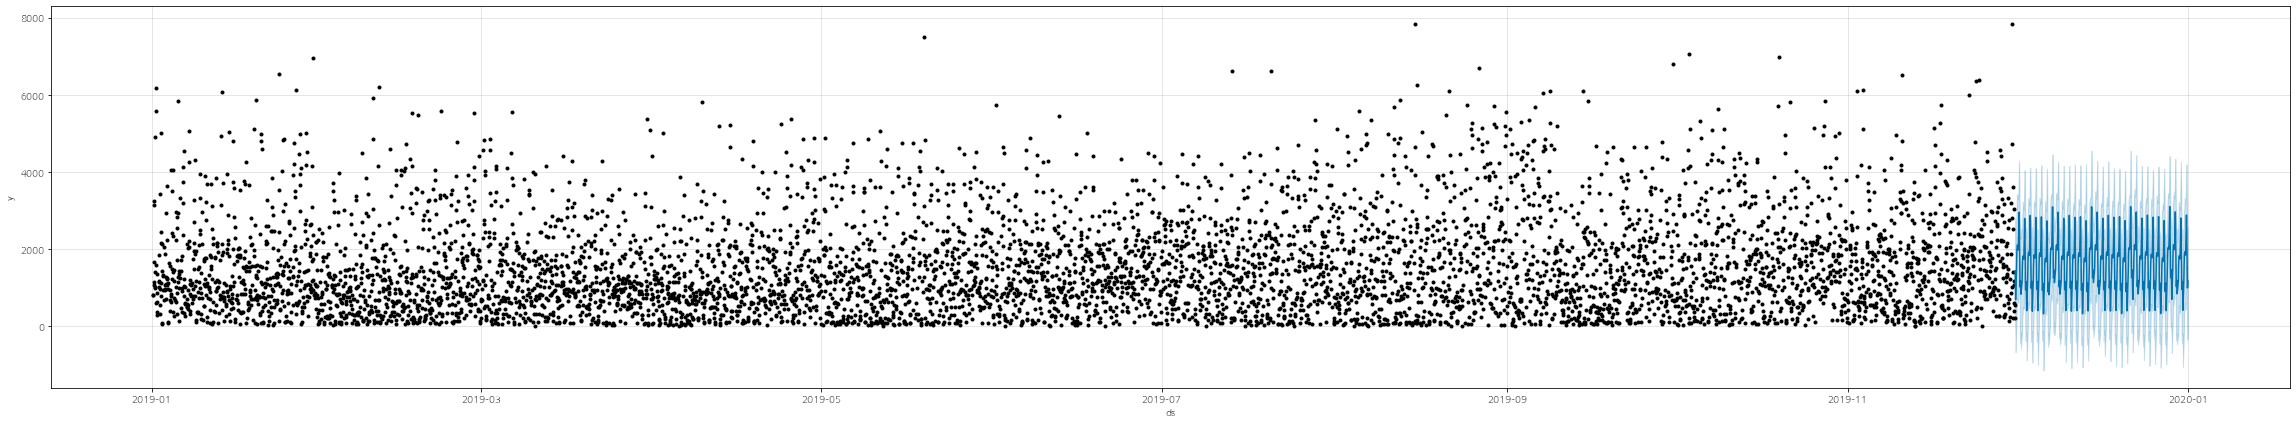

In [ ]:
# prophet plot
m.plot(forecast, figsize=(32, 6));

In [ ]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
hourly['판매량_예측_pred'] = forecast['yhat']
hourly['판매량_예측_lower'] = forecast['yhat_lower']
hourly['판매량_예측_upper'] = forecast['yhat_upper']
hourly

,판매량,판매량_예측_pred,판매량_예측_lower,판매량_예측_upper
날짜시간,,,,
2019-01-01 06:00:00,819.448622,NaN,NaN,NaN
2019-01-01 07:00:00,811.491525,NaN,NaN,NaN
2019-01-01 08:00:00,1665.041736,NaN,NaN,NaN
2019-01-01 09:00:00,1151.556962,NaN,NaN,NaN
2019-01-01 10:00:00,3250.037547,NaN,NaN,NaN
...,...,...,...,...
2019-12-31 19:00:00,1716.880753,1992.175832,644.250601,3322.036641
2019-12-31 20:00:00,432.121912,1345.890179,65.203996,2790.256648
2019-12-31 21:00:00,496.086853,1000.992990,-347.566264,2442.303469


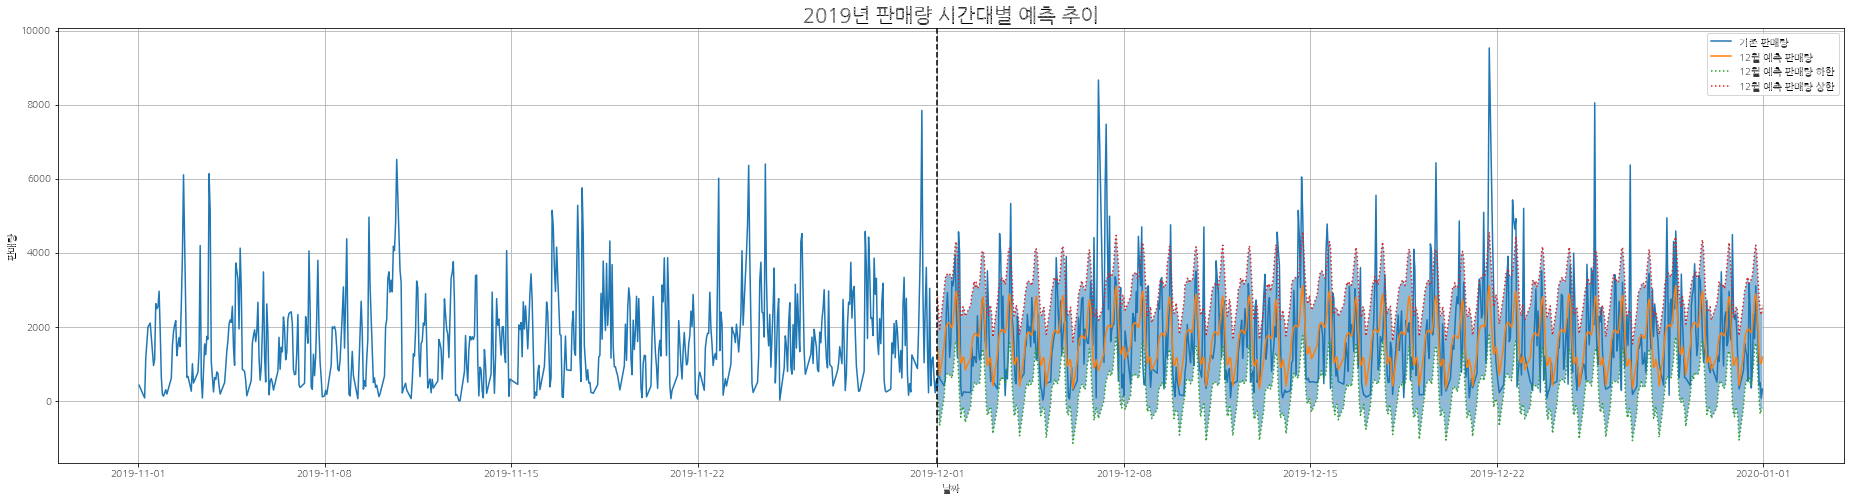

In [ ]:
# 시각화
hourly_for_plot = hourly[hourly.index.month.isin([11, 12])]
hourly_for_plot

plt.figure(figsize=(32, 8))
plt.plot(hourly_for_plot['판매량'], label='기존 판매량')
plt.plot(hourly_for_plot['판매량_예측_pred'], label='12월 예측 판매량')
plt.plot(hourly_for_plot['판매량_예측_lower'], linestyle='dotted', label='12월 예측 판매량 하한')
plt.plot(hourly_for_plot['판매량_예측_upper'], linestyle='dotted', label='12월 예측 판매량 상한')
plt.fill_between(hourly_for_plot.index, hourly_for_plot['판매량_예측_lower'], hourly_for_plot['판매량_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-12-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.title('2019년 판매량 시간대별 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# 스코어 측정
# hourly['취급액_예측_inverse'] = scaler.inverse_transform(hourly['취급액_예측_pred'])
hourly_for_score = hourly.dropna()
print("MAPE:", mean_absolute_percentage_error(hourly_for_score['판매량'], hourly_for_score['판매량_예측_pred']))

MAPE: 108.13699045793068
